In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm, trange
from sklearn.metrics import confusion_matrix
from scipy.stats import poisson, norm
from sklearn.decomposition import PCA
import sys
# sys.path.append("/home/camp/warnert")
# sys.path.append("/home/camp/warnert/working/Recordings/binary_pulses/blip_manuscript")
import blip_analysis as ba
import exp_blip_models as em
import daskify
import dask
from scipy.stats import skewnorm, mannwhitneyu
import scipy
import matplotlib
from sklearn.manifold import LocallyLinearEmbedding, MDS
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from scipy.spatial import distance_matrix
import openephys as oe

b


In [2]:
unit_usrt1, unit_usrt2, unit_usrt3 = ba.load_usrts()

Found odour 1
Found odour 3
Found odour 5


In [3]:
glyphs = ba.get_glyphs()
good_indexes = ba.get_stable_resp_indexes()

In [4]:
def split_bs_data(usrt, test_size=1, bs_size=60):
    train = []
    test = []
    for unit in usrt:
        unit_train = []
        unit_test = []
        for stimuli in unit:
            test_repeat_index = np.random.choice(np.arange(len(stimuli)), size=test_size)
            rest_index = np.arange(len(stimuli))
            rest_index = np.delete(rest_index, test_repeat_index)
            bs_indexes = np.random.choice(rest_index, size=bs_size, replace=True)
            bs_data = stimuli[bs_indexes]
            unit_train.append(bs_data)
            unit_test.append(stimuli[test_repeat_index])
        train.append(unit_train)
        test.append(unit_test)
    train = np.array(train)
    test = np.array(test)
    return train, test

In [5]:
def svm_dask(param, X_train, y_train, X_test, y_test, X_val):
    svm = LinearSVC(C=param, max_iter=10000)
    svm.fit(X_train, y_train)
    test_score = svm.score(X_test, y_test)
    test_pred = svm.predict(X_test)
    val_score = svm.score(X_val, y_test)
    val_pred = svm.predict(X_val)
    return test_score, test_pred, val_score, val_pred

def dask_split_and_fit(usrt_scattered, param, test_size=2, bs_size=60):#, params=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000]):
    train, test = split_bs_data(usrt_scattered, test_size=test_size, bs_size=bs_size)
    X_train = train.sum(axis=-1).reshape(145, -1).T
    X_test = test.sum(axis=-1)[:,:, 0].T
    X_val = test.sum(axis=-1)[:, :, 1].T
    y_train = [i for i in range(32) for j in range(60)]
    y_test = list(range(32))
    test_score, test_pred, val_score, val_pred = svm_dask(param, X_train, y_train, X_test, y_test, X_val)
    return test_score, test_pred, val_score, val_pred, param

In [ ]:
dask_split_and_fit(unit_usrt1[good_indexes], 1)

In [71]:
params=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000, 10000, 1e-12]

In [47]:
params = [1, 10, 100]
pred = svm_dask(params, X_train.T, y_train, X_test.T, y_test, X_val.T)

In [43]:
svm_dask(100, X_train.T, y_train, X_test.T, y_test)

0.1875

In [138]:
outs = [dask_split_and_fit(units_usrt1, 1e-5)[0] for i in trange(10)]



  0%|          | 0/10 [00:00<?, ?it/s]/camp/home/warnert/.conda/envs/intan/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


 10%|█         | 1/10 [00:07<01:03,  7.05s/it]/camp/home/warnert/.conda/envs/intan/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


 20%|██        | 2/10 [00:14<00:56,  7.09s/it]/camp/home/warnert/.conda/envs/intan/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


 30%|███       | 3/10 [00:21<00:50,  7.14s/it]/camp/home/warnert/.conda/envs/intan/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


 40%|████      | 4

In [139]:
print(np.mean(outs))

0.11875


In [137]:
print(len(outs))

100


In [50]:
usrt1_scattered = client.scatter(units_usrt1)

In [77]:
dask_futures = list(np.concatenate([[dask.delayed(dask_split_and_fit)(usrt1_scattered, j) for j in params] for i in range(100)]))

In [78]:
dask_outs = client.compute(dask_futures)

In [76]:
client.cancel(dask_outs)

In [79]:
dasked.current_futures = dask_outs

In [83]:
dasked.check_progress()

finished 1000


In [84]:
res = [i.result() for i in dask_outs]
res = np.array(res)

In [86]:
print(len(res))

1000


In [140]:
client.close()

In [89]:
res = res.reshape(100, 10, 5)


[1e-05 0.0001 0.001 0.01 0.1 1 10 100 1000 10000]


In [122]:

res[:, :, 0].astype(float).std(axis=0)

array([0.05154261, 0.05229125, 0.05680628, 0.05743883, 0.05146677,
       0.05007319, 0.05260406, 0.0579087 , 0.05510909, 0.04977586])

[0.129375 0.11875 0.145625 0.12375 0.133125 0.1265625 0.1275 0.1346875
 0.1253125 0.1334375] [0.05154261 0.05229125 0.05680628 0.05743883 0.05146677 0.05007319
 0.05260406 0.0579087  0.05510909 0.04977586]


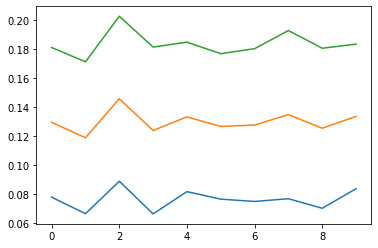

In [130]:
avg_scores = np.mean(res[:, :, 0], axis=0)
std_scores = np.std(res[:, :, 0].astype(float), axis=0)
print(avg_scores, std_scores)
mins = avg_scores - std_scores
maxs = avg_scores + std_scores
plt.plot(mins)
plt.plot(avg_scores)
plt.plot(maxs)


In [25]:
train, test = split_bs_data(units_usrt1, test_size=2)

In [27]:
print(train.shape)
print(test.shape)
X_train = train.sum(axis=-1).reshape(145, -1)
y_train = [i for i in range(32) for j in range(60)]
X_test = test.sum(axis=-1)[:, :, 0]
y_test = list(range(32))
X_val = test.sum(axis=-1)[:, :, 1]

(145, 32, 60, 50)
(145, 32, 2, 50)


In [32]:
params = [1, 10, 100, 1000]
scores = []
for param in tqdm(params, position=0, leave=False):
    svm = LinearSVC(C=param, max_iter=100000)
    svm.fit(X_train.T, y_train)
    scores.append(svm.score(X_test.T, y_test))

In [35]:
max_param_arg = np.argmax(scores)
svm = LinearSVC(C=params[max_param_arg], max_iter=10000)
svm.fit(X_train.T, y_train)
svm.score(X_val.T, y_test)

/camp/home/warnert/.conda/envs/intan/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


0.21875

In [45]:
train, test = split_bs_data(units_usrt1)

In [46]:
print(train.sum(axis=-1).shape)
print(test.sum(axis=-1)[:, :, 0].shape)
y_train = [i for i in range(32) for j in range(60)]


(145, 32, 60)
(145, 32)


In [24]:
train, test = split_bs_data(units_usrt1)
train = train.sum(axis=-1).reshape(145, -1)
test = test.sum(axis=-1).reshape(145, -1)
y_train = [i for i in range(32) for j in range(60)]
y_test = list(range(32))
svm = LinearSVC(C=1000, max_iter=100000)
svm.fit(train.T, y_train)
svm.predict(test.T)

array([ 1,  3,  3,  3,  7,  5,  5, 10, 18, 10, 11, 21, 13, 17, 11, 15, 24,
       17, 20, 20, 16, 14, 20, 13, 26, 12, 25, 23, 27, 28, 27, 29])

In [43]:
def svm_fit(usrt, bs_size=60):
    train, test= split_bs_data(usrt)
    train = train.sum(axis=-1).reshape(145, -1)
    test = test.sum(axis=-1).reshape(145, -1)
    y_train = [i for i in range(32) for j in range(bs_size)]
    y_test = list(range(32))
    svm = LinearSVC(C=1000, max_iter=100000)
    svm.fit(train.T, y_train)
    pred = svm.predict(test.T)
    return pred, y_test

In [320]:
joined_usrt = np.concatenate([units_usrt1, units_usrt2, units_usrt3], axis=1)
print(joined_usrt.shape)

(145, 96)


In [365]:
train, test = split_bs_data(units_usrt1)
onset = 10
window_size = 50
train[:, :, :, onset:onset+window_size]
test.shape

(145, 32, 1, 212)

In [321]:
def svm_fit_all(usrts, bs_size=60):
    train, test= split_bs_data(usrts)
    train = train.sum(axis=-1).reshape(145, -1)
    test = test.sum(axis=-1).reshape(145, -1)
    y_train = [i for i in range(96) for j in range(bs_size)]
    y_test = list(range(96))
    svm = LinearSVC(C=1000, max_iter=100000)
    svm.fit(train.T, y_train)
    pred = svm.predict(test.T)
    return pred, y_test

In [369]:
def svm_fit_window(usrt, onset, window_size, bs_size=60):
    train, test= split_bs_data(usrt)
    train =train[:, :, :, onset:onset+window_size].sum(axis=-1).reshape(145, -1)
    test =test[:, :, :, onset:onset+window_size].sum(axis=-1).reshape(145, -1)
    y_train = [i for i in range(32) for j in range(bs_size)]
    y_test = list(range(32))
    svm = LinearSVC(C=1000, max_iter=100000)
    svm.fit(train.T, y_train)
    pred = svm.predict(test.T)
    return pred, y_test, onset

In [370]:
pred, y_test, onset = svm_fit_window(units_usrt1, 10, 50)

/camp/home/warnert/.conda/envs/intan/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [373]:
print(onset)

10


In [47]:
pred, y_test = svm_fit(units_usrt1)

/camp/home/warnert/.conda/envs/intan/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [36]:
dasked = daskify.Daskified()

In [37]:
dasked.start_cluster()

In [38]:
client = dasked.client

In [48]:
scatterd_usrt1 = client.scatter(units_usrt1)
scatterd_usrt2 = client.scatter(units_usrt2)
scatterd_usrt3 = client.scatter(units_usrt3)

In [322]:
scattered_joined = client.scatter(joined_usrt)

In [49]:
futures1 = [dask.delayed(svm_fit)(scatterd_usrt1) for i in range(500)]
futures2 = [dask.delayed(svm_fit)(scatterd_usrt2) for i in range(500)]
futures3 = [dask.delayed(svm_fit)(scatterd_usrt3) for i in range(500)]

In [323]:
futures = [dask.delayed(svm_fit_all)(scattered_joined) for i in range(500)]

In [425]:
futures = [[dask.delayed(svm_fit_window)(scatterd_usrt1, j, 50) for i in range(100)] for j in range(212-50)]
futures = list(np.concatenate(futures))

In [410]:
print(futures[0])

Delayed('svm_fit_window-04192990-9ba1-428b-9ee5-d852642575aa')


In [415]:
client.close()

In [50]:
dask_outs1 = client.compute(futures1)
dask_outs2 = client.compute(futures2)
dask_outs3 = client.compute(futures3)

In [55]:
status = np.array([i.status for i in dask_outs1])
print(list(set(status)))
for i in list(set(status)):
    print(i, len(status[status == i]))
    
status = np.array([i.status for i in dask_outs2])
print(list(set(status)))
for i in list(set(status)):
    print(i, len(status[status == i]))
    
status = np.array([i.status for i in dask_outs3])
print(list(set(status)))
for i in list(set(status)):
    print(i, len(status[status == i]))

['finished']
finished 500
['finished']
finished 500
['finished']
finished 500


In [412]:
print(dask_outs[0][0][0].status)

Delayed('getattr-e36c12da7d6a5f8f56d1d0e49b39ac97')


In [422]:
print(dask_outs[0].status)

Delayed('getattr-668ee730701f863bef8cebec7c52cdad')


In [561]:
status = np.array([i.status for i in dask_outs])
print(list(set(status)))
for i in list(set(status)):
    print(i, len(status[status == i]))

['finished']
finished 16200


In [562]:
reses_window = [i.result() for i in tqdm(dask_outs, position=0, leave=False)]

100%|█████████▉| 16145/16200 [00:28<00:00, 588.26it/s]


In [563]:
onsets = [i[-1] for i in reses_window]
reses_window = [[i[0], i[1]] for i in reses_window]

In [56]:
reses1 = [i.result() for i in dask_outs1]
reses2 = [i.result() for i in dask_outs2]
reses3 = [i.result() for i in dask_outs3]

In [59]:
preds1 = np.array(reses1)[:, 0].reshape(500, 32)
trues1 = np.array(reses1)[:, 1].reshape(500, 32)
preds2 = np.array(reses2)[:, 0].reshape(500, 32)
trues2 = np.array(reses2)[:, 1].reshape(500, 32)
preds3 = np.array(reses3)[:, 0].reshape(500, 32)
trues3 = np.array(reses3)[:, 1].reshape(500, 32)

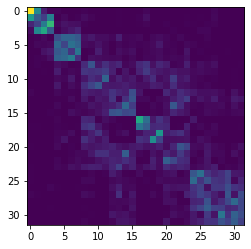

In [62]:
cm1 = confusion_matrix(np.concatenate(trues1), np.concatenate(preds1), normalize='true', labels=range(32))


In [63]:
all_reses = np.array([reses1, reses2, reses3])
np.save('221027_all_svm_outs.npy', all_reses)

In [6]:
all_reses = np.load('221027_all_svm_outs.npy')
preds1 = np.array(all_reses)[0, :, 0].reshape(500, 32)
trues1 = np.array(all_reses)[0, :, 1].reshape(500, 32)
preds2 = np.array(all_reses)[1, :, 0].reshape(500, 32)
trues2 = np.array(all_reses)[1, :, 1].reshape(500, 32)
preds3 = np.array(all_reses)[2, :, 0].reshape(500, 32)
trues3 = np.array(all_reses)[2, :, 1].reshape(500, 32)
cm1 = confusion_matrix(np.concatenate(trues1), np.concatenate(preds1), normalize='true', labels=range(32))
cm2 = confusion_matrix(np.concatenate(trues2), np.concatenate(preds2), normalize='true', labels=range(32))
cm3 = confusion_matrix(np.concatenate(trues3), np.concatenate(preds3), normalize='true', labels=range(32))

In [574]:
reses_window = np.array(reses_window)
onsets = np.array(onsets)
preds_window = reses_window[:, 0].reshape(162, 100, 32)
trues_window = reses_window[:, 1].reshape(162, 100, 32)
print(preds_window.shape)
print(preds_window.reshape(162, 100, 32).shape)
onsets_reshape = onsets.reshape(162, 100)


(162, 100, 32)
(162, 100, 32)


In [577]:
print(trues_window[0].shape)

(100, 32)


In [578]:
cms_window = np.array([confusion_matrix(np.concatenate(trues_window[i]), np.concatenate(preds_window[i]), labels=list(range(32)), normalize='true') for i in range(162)])

In [590]:
print(np.max(cms_window))

0.74


In [596]:
avg_accs = [np.mean([i[j, j] for j in range(32)]) for i in cms_window]

In [620]:
np.save('221017_preds_window.npy', preds_window)
np.save('221017_trues_window.npy', trues_window)

In [31]:
preds_window = np.load('221017_preds_window.npy')
trues_window = np.load('221017_trues_window.npy')
print(preds_window.shape)

(162, 100, 32)


NameError: name 'cms_window' is not defined

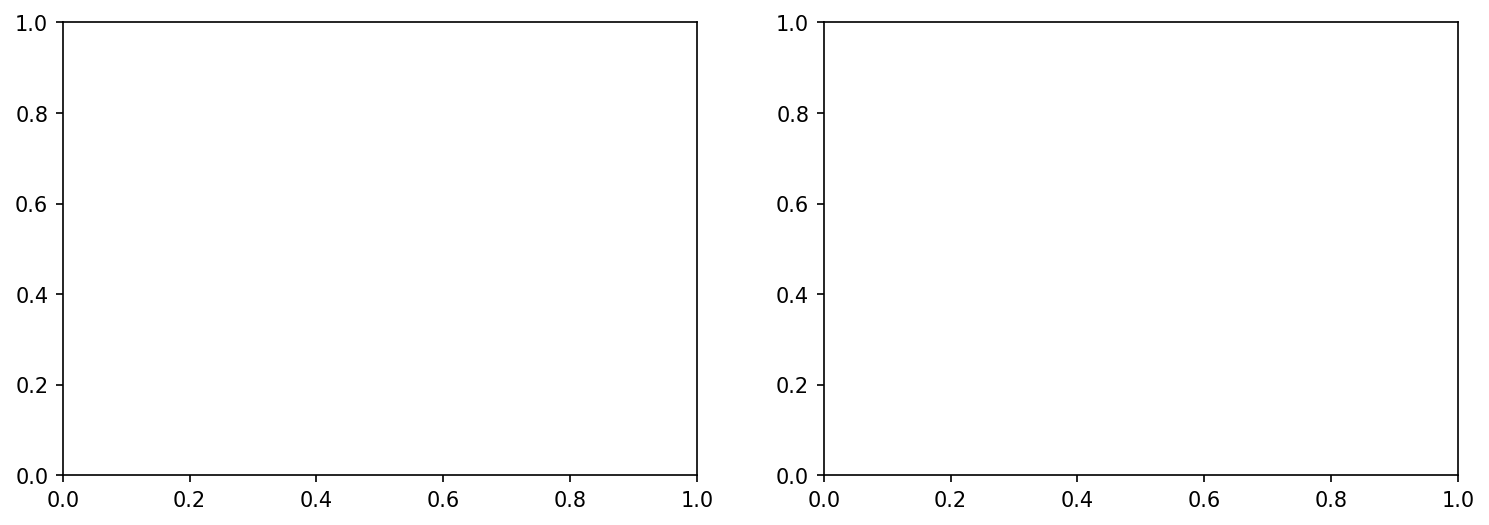

In [5]:


times = np.arange(-1, 0.62, 1/100)
for index, i in enumerate(times):
    fig,ax = plt.subplots(1, 2, figsize=(12, 4), dpi=150)
    im = ax[1].imshow(cms_window[index], cmap='pink')#, vmax=0.74)
    fig.suptitle(f'Onset: {i:0.2}s')
    ax[1].set_xticks(range(32))
    ax[1].set_xticklabels(glyphs, rotation=90, fontsize=9)
    ax[1].set_yticks(range(32))
    ax[1].set_yticklabels(glyphs, fontsize=9)
    plt.colorbar(ax = ax[1], mappable=im)
    ax[1].set_ylim(31.5, -.5)
    
    ax[0].plot(times, avg_accs, color='k')
    ax[0].scatter(i, avg_accs[index], color='r', zorder=10)
    ax[0].axvspan(-.5, 0, color='lightgray')
    ax[0].set_xlabel('Onset (s)')
    ax[0].set_ylabel('Average accuracy')
    ax[1].set_ylabel('True label')
    ax[1].set_xlabel('Predicted label')
    plt.savefig(f'Avg_accuracy_cm_no_vmax//{index}.png')
    plt.close()

In [ ]:
reses = [i.result() for i in tqdm(dask_outs)]

In [345]:
reses = np.array(reses)
print(reses.shape)

(500, 2, 96)


In [346]:
preds = reses[:, 0]
trues = reses[:, 1]

In [347]:
cm = confusion_matrix(np.concatenate(trues), np.concatenate(preds), labels=list(range(96)), normalize='true')

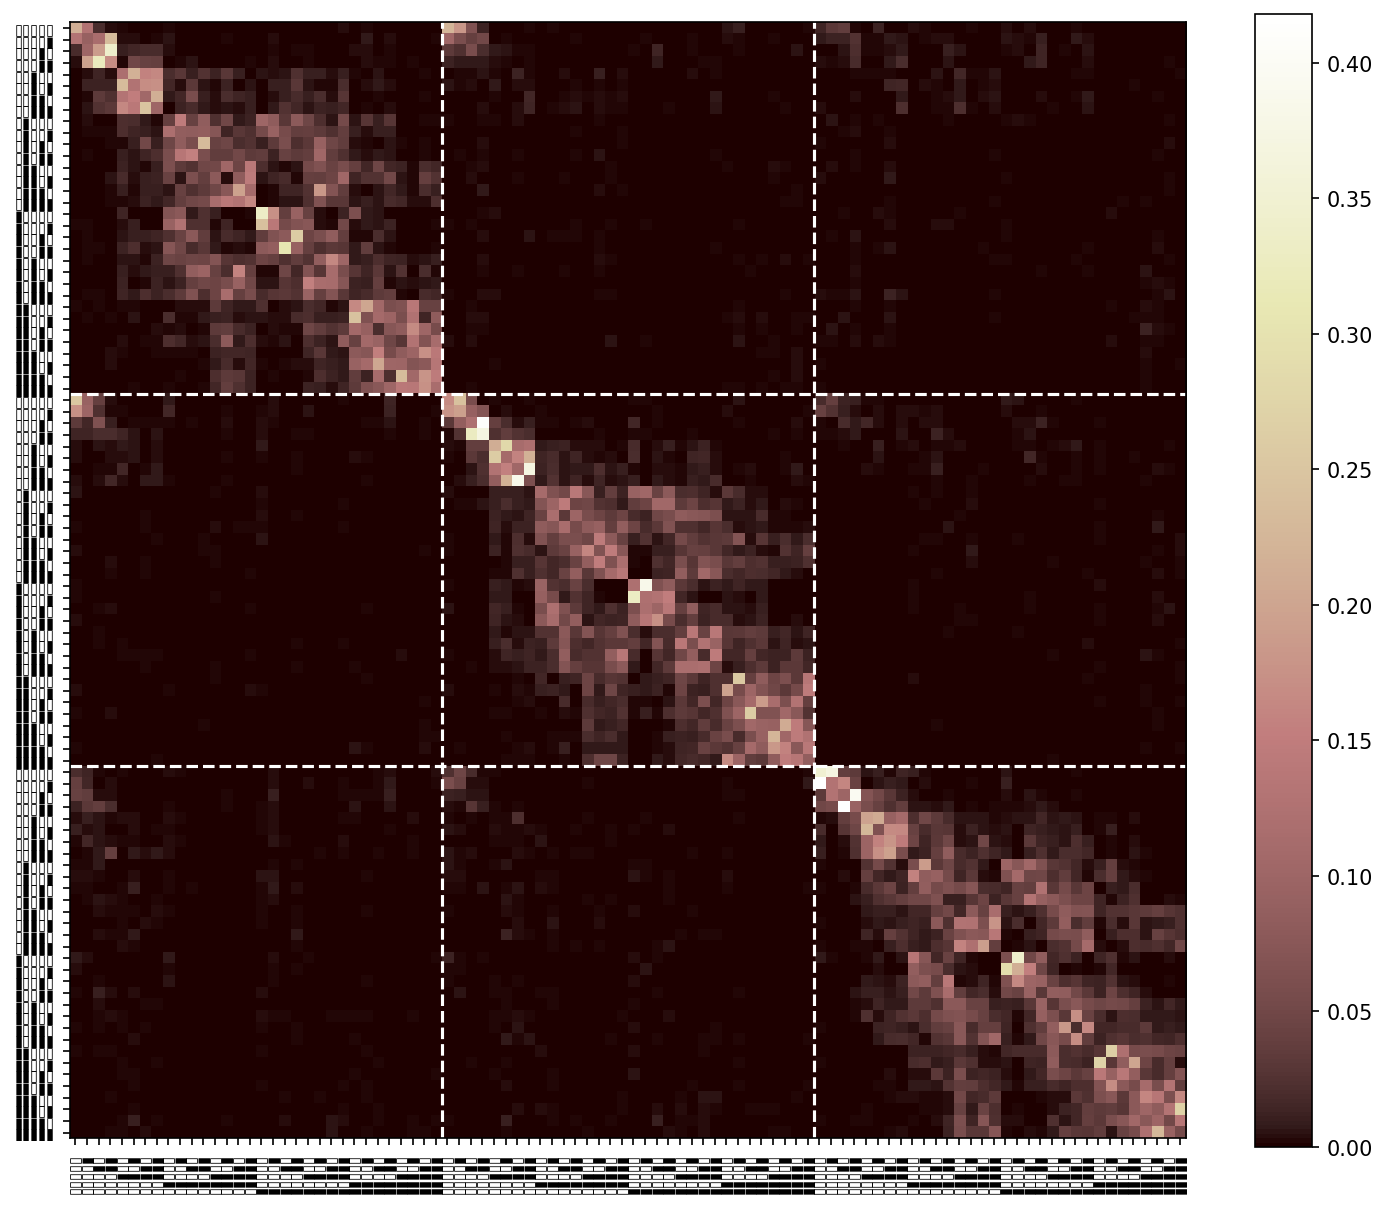

In [358]:
plt.figure(figsize=(12, 10), dpi=150)

plt.imshow(cm, cmap='pink')
plt.xticks(range(96), labels=glyphs*3, rotation=90, fontsize=7);
plt.yticks(range(96), labels=glyphs*3, fontsize=7);
plt.ylim(95.5, -.5)
plt.colorbar()
plt.axhline(31.5, linestyle='--', color='white')
plt.axhline(63.5, linestyle='--', color='white')

plt.axvline(31.5, linestyle='--', color='white')
plt.axvline(63.5, linestyle='--', color='white')

(1.5, -0.5)

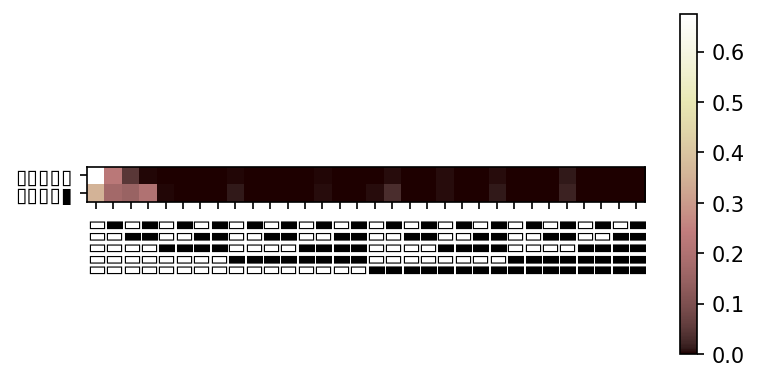

In [315]:
plt.figure(figsize=(6, 3), dpi=150)
plt.imshow(cm[:2], cmap='pink')
plt.xticks(range(32), labels=glyphs, rotation=90, fontsize=10);
plt.yticks(range(2), labels=glyphs[:2], fontsize=10);
plt.colorbar()
plt.ylim(1.5, -.5)


In [ ]:
cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone',
                      'pink', 'spring', 'summer', 'autumn', 'winter', 'cool',
                      'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper','Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
for i in range(len(cmaps)):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, cmap=cmaps[i], vmin=0)
    plt.title(cmaps[i])
    plt.xticks(range(32), labels=glyphs, rotation=90, fontsize=9)
    plt.yticks(range(32), labels=glyphs, fontsize=9)
    plt.ylim(31.5, -.5)
    plt.colorbar()

In [7]:
mean_usrt1 = np.array([[np.mean(i, axis=0) for i in j] for j in unit_usrt1])
mean_usrt2 = np.array([[np.mean(i, axis=0) for i in j] for j in unit_usrt2])
mean_usrt3 = np.array([[np.mean(i, axis=0) for i in j] for j in unit_usrt3])
print(mean_usrt2.shape)

(145, 32, 50)


In [9]:
mean_usrt1.shape

(145, 32, 50)

In [25]:
mean_usrt1_scattered = client.scatter(mean_usrt)

In [8]:
dms1 = [distance_matrix(mean_usrt1[:, :, i].T, mean_usrt1[:, :, i].T) for i in range(162)]
dms2 = [distance_matrix(mean_usrt2[:, :, i].T, mean_usrt2[:, :, i].T) for i in range(162)]
dms3 = [distance_matrix(mean_usrt3[:, :, i].T, mean_usrt3[:, :, i].T) for i in range(162)]

IndexError: index 50 is out of bounds for axis 2 with size 50

In [12]:
def de_minimisation(coords, true_distances):
    coords = coords[:, np.newaxis]
    #print(coords)

    dm = distance_matrix(coords, coords)
#     dm_off = np.triu(dm, 1)

    loss = np.sum(np.abs(true_distances.ravel() - dm.ravel()))
    return loss

def de_minimisation_across(coords, true_distances, prev_coords, alpha):
    coords = coords[:, np.newaxis]
    
    dm = distance_matrix(coords, coords)
    coords_normed = coords - coords.mean()
    if np.sum((coords - prev_coords)**2) > np.sum((coords + prev_coords)**2):
        coords_diff = np.sum((coords + prev_coords)**2)
    else:
        coords_diff = np.sum((coords - prev_coords)**2)
    loss = np.sum((true_distances.ravel() - dm.ravel())**2) + alpha*coords_diff #+ np.mean(coords)
    return loss

def dask_de_minimisation(true_distances):
    bounds = [[0, 1000]]*32
    de = scipy.optimize.differential_evolution(de_minimisation, bounds=bounds, args=[true_distances], popsize=50, tol=0.001, maxiter=10000, )
    coords = de.x
    coords = coords - coords.mean()
    return coords

def flip_distances(distances):
    distances_normed = distances - np.mean(distances, axis=1)[:, np.newaxis]
    distances_flipped = [distances_normed[0]]
    for i in range(1, len(distances)):
        prev_distance = distances_flipped[-1]
        distance = distances_normed[i]
        if np.sum(abs(distance - prev_distance )) < np.sum(abs(distance + prev_distance)):
            distances_flipped.append(distance)
        else:
            distances_flipped.append(-distance)
    return distances_flipped

def flip_flip_distances(distances):
    flipped_distances = np.array([flip_distances(i) for i in distances])
    flipped_flipped_distances = [flipped_distances[0]]

    for i in range(1, len(flipped_distances)):
        if np.sum(np.abs(flipped_distances[0]+flipped_distances[i])) > np.sum(np.abs(flipped_distances[0]-flipped_distances[i])):
            flipped_flipped_distances.append(flipped_distances[i])
        else:
            flipped_flipped_distances.append(-flipped_distances[i])
    return np.array(flipped_flipped_distances)

In [26]:
futures = np.concatenate([[dask.delayed(dask_de_minimisation)(i) for i in dms3[100:]] for j in range(50)])
outs = client.compute(list(futures))
dasked.current_futures = outs

In [36]:
dasked.check_progress()

finished 3100


In [37]:
res = [i.result() for i in tqdm(outs, position=0, leave=False)]

In [38]:
res = np.array(res).reshape(50, 62, 32)


In [169]:
print(res.shape)
print(res1.shape)
res1_joined = np.append(res1, res, axis=1)
np.save('221026_de_1d_res_odour1_extended.npy', res1_joined)

(50, 62, 32)
(50, 100, 32)


In [25]:
res.shape
res2_joined = np.append(res2, res, axis=1)
np.save('221027_de_1d_res_odour2_extended.npy', res2_joined)

In [39]:
res.shape
res3_joined = np.append(res3, res, axis=1)
np.save('221027_de_1d_res_odour3_extended.npy', res3_joined)

In [82]:
np.save('221025_de_1d_res.npy', res)

In [80]:
np.save('221026_de_1d_res_odour2.npy', res)

In [117]:
np.save('221027_de_1d_res_odour3.npy', res)

In [10]:
res1 = np.load('221026_de_1d_res_odour1_extended.npy')
res2 = np.load('221027_de_1d_res_odour2_extended.npy')
res3 = np.load('221027_de_1d_res_odour3_extended.npy')
res1 = np.array(res1).reshape(50, 162, 32)
res2 = np.array(res2).reshape(50, 162, 32)
res3 = np.array(res3).reshape(50, 162, 32)

In [13]:
flipped_distances1 = np.array([flip_distances(i) for i in res1])
flipped_distances2 = np.array([flip_distances(i) for i in res2])

In [14]:
flipped_flipped_distances1 = flip_flip_distances(res1)
flipped_flipped_distances2 = flip_flip_distances(res2)
flipped_flipped_distances3 = flip_flip_distances(res3)

In [15]:
mean_ffd1 = np.mean(flipped_flipped_distances1, axis=0)
closest1 = np.argmin((mean_ffd1 - flipped_flipped_distances1)**2, axis=0)
mean_ffd2 = np.mean(flipped_flipped_distances2, axis=0)
closest2 = np.argmin((mean_ffd2 - flipped_flipped_distances2)**2, axis=0)


In [16]:
print(flipped_flipped_distances.shape)

NameError: name 'flipped_flipped_distances' is not defined

In [17]:
closests1 = [flipped_flipped_distances1[0, 0]]
closests2 = [flipped_flipped_distances2[0, 0]]
closests3 = [flipped_flipped_distances3[0, 0]]
for i in range(1, 162):
    prev_distance = closests1[-1]
    diffs = np.mean(np.abs(flipped_flipped_distances1[:, i] - prev_distance), axis=-1)
    min_diff = np.argmin(diffs)
    closests1.append(flipped_flipped_distances1[min_diff, i])
    
    prev_distance = closests2[-1]
    diffs = np.mean(np.abs(flipped_flipped_distances2[:, i] - prev_distance), axis=-1)
    min_diff = np.argmin(diffs)
    closests2.append(flipped_flipped_distances2[min_diff, i])
    
    prev_distance = closests3[-1]
    diffs = np.mean(np.abs(flipped_flipped_distances3[:, i] - prev_distance), axis=-1)
    min_diff = np.argmin(diffs)
    closests3.append(flipped_flipped_distances3[min_diff, i])

# for i in np.array(closests).T:
#     plt.plot(i)

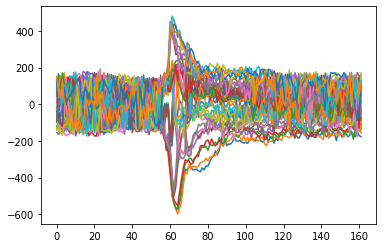

In [18]:
for i in np.array(closests3).T:
    plt.plot(i)

In [19]:
test = np.zeros((100, 32))
for i in range(100):
    for j in range(32):
        test[i, j] = flipped_flipped_distances[closest[i, j], i, j]
for i in test.T:
    plt.plot(i)

NameError: name 'flipped_flipped_distances' is not defined

In [ ]:
for i in range(32):
    plt.plot(flipped_flipped_distances[closest[:, i], :, i])

Text(0.5, 0, 'Time (s)')

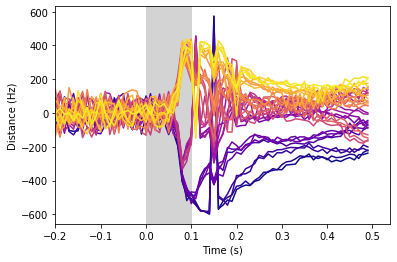

In [108]:
med_flipped = np.median(flipped_flipped_distances, axis=0)
xs = np.arange(-.5, .5, 1/100)
for i in range(32):
    plt.plot(xs, med_flipped[:, i], color=matplotlib.cm.plasma(i/32))
plt.axvspan(0, .1, color='lightgray')
plt.xlim(-0.2,)
plt.ylabel('Distance (Hz)')
plt.xlabel('Time (s)')


Text(0.5, 0, 'Time (s)')

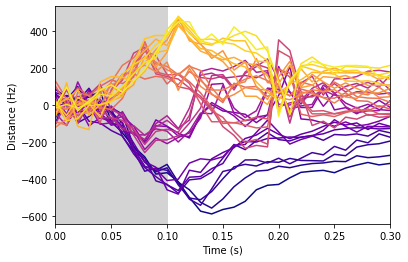

In [20]:
med_flipped = np.median(flipped_flipped_distances, axis=0)
xs = np.arange(-.5, .5, 1/100)
for i in range(32):
    plt.plot(xs, med_flipped[:, i], color=matplotlib.cm.plasma(i/32))
plt.axvspan(0, .1, color='lightgray')
plt.xlim(0,0.3)
plt.ylabel('Distance (Hz)')
plt.xlabel('Time (s)')


In [26]:
print(mean_usrt1.shape)

dm_avg1 = distance_matrix(mean_usrt1.mean(axis=-1).T, mean_usrt1.mean(axis=-1).T)
dm_avg2 = distance_matrix(mean_usrt2.mean(axis=-1).T, mean_usrt2.mean(axis=-1).T)
dm_avg3 = distance_matrix(mean_usrt3.mean(axis=-1).T, mean_usrt3.mean(axis=-1).T)


(145, 32, 50)


In [120]:
### Trial with rolling window distance matrix
ws = 10
dms_roll = [distance_matrix(np.mean(mean_usrt[:, :, i:i+ws], axis=-1).T, np.mean(mean_usrt[:, :, i:i+ws], axis=-1).T) for i in range(50-ws)]


bounds = [[-1000, 1000]]*32
print(bounds)
des = []
for i in tqdm(range(50-ws)):
    de = scipy.optimize.differential_evolution(de_minimisation, bounds=bounds, args=[dms_roll[i]])
    des.append(de)
distances = np.array([i.x for i in des])

distances_normed = distances - np.mean(distances, axis=1)[:, np.newaxis]
distances_flipped = [distances_normed[0]]
for i in range(1, 50-ws):
    prev_distance = distances_flipped[i-1]
    distance = distances_normed[i]
    #print(distance)
    #rint(prev_distance)
#     print(np.sum(abs(distance - prev_distance)), np.sum(abs(distance + prev_distance)))
#     print('a')
    if np.sum(abs(distance - prev_distance )) < np.sum(abs(distance + prev_distance)):
        distances_flipped.append(distance)
    else:
        distances_flipped.append(-distance)

In [ ]:
### Trialing with a penalty for having coords too different from the previous time point
alpha = 2
bounds = [[0, 1000]]*32
print(bounds)
reps = 5
all_distances = []
for j in range(reps):
    de = scipy.optimize.differential_evolution(de_minimisation, bounds=bounds, args=[dms[0]])
    distances = [de.x]
    for i in tqdm(range(1, 20)):
    #     print(distances[-1])
        de = scipy.optimize.differential_evolution(de_minimisation_across, bounds=bounds, args=[dms[i], distances[-1], alpha], init='sobol')
        distances.append(de.x)
#     distances = np.array(distances)
    all_distances.append(distances)

In [135]:
all_distances_flipped = []
for distances in all_distances:
    distances_normed = distances - np.mean(distances, axis=1)[:, np.newaxis]
    distances_flipped = [distances_normed[0]]
    for i in range(1, 20):
        prev_distance = distances_flipped[i-1]
        distance = distances_normed[i]
        #print(distance)
        #rint(prev_distance)
    #     print(np.sum(abs(distance - prev_distance)), np.sum(abs(distance + prev_distance)))
    #     print('a')
        if np.sum(abs(distance - prev_distance )) < np.sum(abs(distance + prev_distance)):
            distances_flipped.append(distance)
        else:
            distances_flipped.append(-distance)
    all_distances_flipped.append(distances_flipped)

In [20]:
def plot_1d_distance_graph(xs, distances, ax, colors=None):
    distances = np.array(distances)
    trial_len = distances.shape[1]
    if colors is None:
        colors = [matplotlib.cm.plasma(i/trial_len) for i in range(trial_len)]

    print(len(colors))
    for index, i in enumerate(distances.T):
        ax.plot(xs, i, color=colors[index])
    ax.axvspan(0, 0.1, color='lightgray')
    
def distance_plots(fig, gs_base, xs, closests):

    sub_gridspec = gs_base.subgridspec(ncols=14, nrows=2, wspace=1.5)
    big_ax = fig.add_subplot(sub_gridspec[0, 2:])
    small_ax1 = fig.add_subplot(sub_gridspec[1, 2:6])
    small_ax2 = fig.add_subplot(sub_gridspec[1, 6:10])
    small_ax3 = fig.add_subplot(sub_gridspec[1, 10:])
    
    small_ax2.set_yticklabels([])
    small_ax3.set_yticklabels([])
    plot_1d_distance_graph(xs, closests1, big_ax)

    cbar_ax = fig.add_subplot(sub_gridspec[:, 0])
    cbar_ax.yaxis.set_ticks_position('left')
    plot_cbar_and_glyphs(cbar_ax, glyphs)
    cbar_ax.yaxis.set_ticks_position('left')
    plot_1d_distance_graph(xs[50:70], closests1[50:70], small_ax1)
    plot_1d_distance_graph(xs[50:70], closests2[50:70], small_ax2)
    plot_1d_distance_graph(xs[50:70], closests3[50:70], small_ax3)
    
    min_max = np.max(np.abs(np.concatenate([small_ax1.get_ylim(), small_ax2.get_ylim(), small_ax3.get_ylim()])))
    small_ax1.set_ylim(-min_max, min_max)
    small_ax2.set_ylim(-min_max, min_max)
    small_ax3.set_ylim(-min_max, min_max)
    label_ax = fig.add_subplot(sub_gridspec[:, 2:], frameon=False)
    label_ax.set_xticks([])
    label_ax.set_yticks([])
    label_ax.set_ylabel('Distance (Hz)', labelpad=27)
    label_ax.set_xlabel('Time (s)', labelpad=20)

32
32
32
32


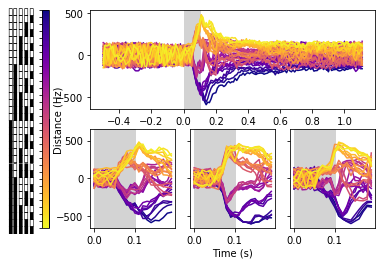

In [25]:
fig = plt.figure()
gs = GridSpec(1, 1)
xs = np.arange(-.5, 1.12, 1/100)

distance_plots(fig, gs[0], xs, [closests1, closests2, closests3])


32
32
32
32


NameError: name 'cm1' is not defined

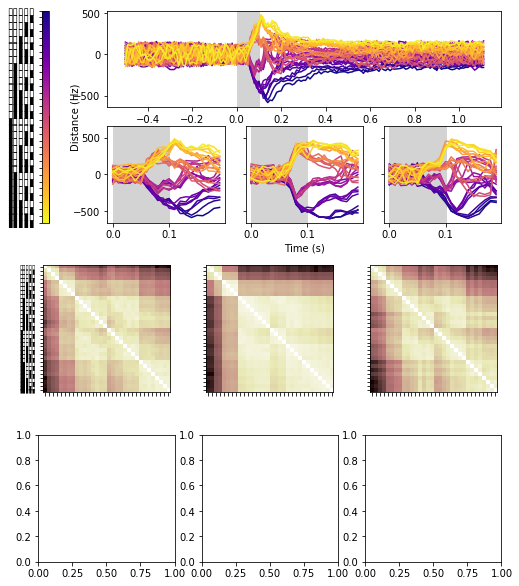

In [27]:
fig = plt.figure(figsize=(8.3, 11.7))
gs = GridSpec(8, 3, hspace=1)
# distance_ax1 = fig.add_subplot(gs[0, :2])
# distance_ax1_zoom = fig.add_subplot(gs[0, 2:])
# distance_ax2 = fig.add_subplot(gs[1, :2])
# distance_ax2_zoom = fig.add_subplot(gs[1, 2:])
# distance_ax3 = fig.add_subplot(gs[2, :2])
# distance_ax3_zoom = fig.add_subplot(gs[2, 2:])
xs = np.arange(-.5, 1.12, 1/100)
# plot_1d_distance_graph(xs, closests1, distance_ax1)
# plot_1d_distance_graph(xs[50:70], closests1[50:70], distance_ax1_zoom)
# plot_1d_distance_graph(xs, closests2, distance_ax2)
# plot_1d_distance_graph(xs[50:70], closests2[50:70], distance_ax2_zoom)
# plot_1d_distance_graph(xs, closests3, distance_ax3)
# plot_1d_distance_graph(xs[50:70], closests3[50:70], distance_ax3_zoom)
distance_plots(fig, gs[:3, :], xs, [closests1, closests2, closests3])

dm_ax1 = fig.add_subplot(gs[3:5, 0])
dm_ax2 = fig.add_subplot(gs[3:5, 1])
dm_ax3 = fig.add_subplot(gs[3:5, 2])
dm_ax1.imshow(dm_avg1, cmap='pink_r')
dm_ax2.imshow(dm_avg2, cmap='pink_r')
dm_ax3.imshow(dm_avg3, cmap='pink_r')
dm_ax1.set_yticks(range(32))
dm_ax1.set_yticklabels(glyphs, fontsize=6)
dm_ax2.set_yticks(range(32))
dm_ax3.set_yticks(range(32))
dm_ax2.set_yticklabels([])
dm_ax3.set_yticklabels([])
dm_ax1.set_xticks(range(32))
dm_ax2.set_xticks(range(32))
dm_ax3.set_xticks(range(32))
dm_ax1.set_xticklabels([])#glyphs, rotation=90);
dm_ax2.set_xticklabels([])#glyphs, rotation=90);
dm_ax3.set_xticklabels([])#glyphs, rotation=90);


# [t.set_color(i) for (i,t) in
#  zip([matplotlib.cm.plasma(j/32) for j in range(32)],dm_ax1.yaxis.get_ticklabels())]

# [t.set_color(i) for (i,t) in
#  zip([matplotlib.cm.plasma(j/32) for j in range(32)],dm_ax1.xaxis.get_ticklabels())]

# [t.set_color(i) for (i,t) in
#  zip([matplotlib.cm.plasma(j/32) for j in range(32)],dm_ax2.xaxis.get_ticklabels())]

# [t.set_color(i) for (i,t) in
#  zip([matplotlib.cm.plasma(j/32) for j in range(32)],dm_ax3.xaxis.get_ticklabels())]


dm_ax1.set_ylim(31.5, -.5)
dm_ax2.set_ylim(31.5, -.5)
dm_ax3.set_ylim(31.5, -.5)

cm_ax1 = fig.add_subplot(gs[5:7, 0])
cm_ax2 = fig.add_subplot(gs[5:7, 1])
cm_ax3 = fig.add_subplot(gs[5:7, 2])
cm_ax1.imshow(cm1, cmap='pink')
cm_ax2.imshow(cm2, cmap='pink')
cm_ax3.imshow(cm3, cmap='pink')
cm_ax1.set_yticks(range(32))
cm_ax1.set_yticklabels(glyphs, fontsize=6)
cm_ax2.set_yticks(range(32))
cm_ax2.set_yticklabels([])
cm_ax3.set_yticks(range(32));
cm_ax3.set_yticklabels([]);
cm_ax1.set_xticks(range(32))
cm_ax1.set_xticklabels(glyphs, rotation=90, fontsize=6)
cm_ax2.set_xticks(range(32))
cm_ax2.set_xticklabels(glyphs, rotation=90, fontsize=6)
cm_ax3.set_xticks(range(32))
cm_ax3.set_xticklabels(glyphs, rotation=90, fontsize=6);


In [ ]:
#Use different colourmap for distance confusion matrix
#Try changing the color of the dm labels to match the 1d plot
#Try ordering by gray-code for pattern - read up about it

In [24]:
def plot_cbar_and_glyphs(ax, glyphs, cmap='plasma_r'):
    im = ax.imshow(np.array([[0, 1]]), aspect=30, cmap=cmap)
    cbar = plt.colorbar(cax=ax, mappable=im)
    cbar.set_ticks(np.linspace(0, 1, len(glyphs)))
    cbar.set_ticklabels(glyphs[::-1])

32
32
32
32


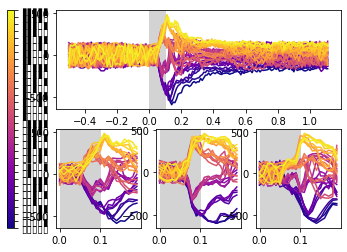

In [34]:
fig = plt.figure()
gs = GridSpec(1, 1)
sub_gridspec = gs[0].subgridspec(ncols=14, nrows=2, wspace=1.5)
big_ax = fig.add_subplot(sub_gridspec[0, 2:])
small_ax1 = fig.add_subplot(sub_gridspec[1, 2:6])
small_ax2 = fig.add_subplot(sub_gridspec[1, 6:10])
small_ax3 = fig.add_subplot(sub_gridspec[1, 10:])
plot_1d_distance_graph(xs, closests1, big_ax)

cbar_ax = fig.add_subplot(sub_gridspec[:, 0])
plot_cbar_and_glyphs(cbar_ax, glyphs)
plot_1d_distance_graph(xs[50:70], closests1[50:70], small_ax1)
plot_1d_distance_graph(xs[50:70], closests2[50:70], small_ax2)
plot_1d_distance_graph(xs[50:70], closests3[50:70], small_ax3)
